<a href="https://colab.research.google.com/github/aoran1102/aoran1102.github.io/blob/master/LendingClub_Loan_Default_%26_Interest_Rate_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LendingClub Loan Default & Interest Rate Prediction

#Background
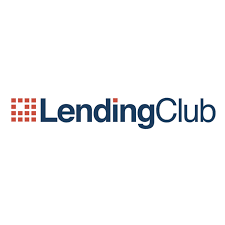

LendingClub,is a trailblazer in the U.S. peer-to-peer lending industry, notable for being the first such company to register its offerings with the SEC and to facilitate loan trading on a secondary market. In this project, we leverages this rich context by supervised learning models to predict potential loan defaults and determine appropriate interest rates for loans issued through LendingClub's online platform. By predicting default probabilities and interest rates, the project aims to enhance risk management and pricing strategies, thus supporting LendingClub's mission to provide a secure and efficient lending environment for borrowers and investors alike.

# Part 0: Setup Google Drive Environment & Load Data



In [1]:
import pandas as pd
import numpy as np

from tabulate import tabulate


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# correlation heat map of numerical features
import seaborn as sns
import matplotlib.pyplot as plt

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=1VOAhrB5eIhFc8C5qeFx5QYa2OLD7s1eV'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id})
file.GetContentFile('loan-clean-version.csv')
df  = pd.read_csv('loan-clean-version.csv')


# Part 1: Data Exploration

#1.1 Understand the Raw Dataset

We have a dataset consisting of 9,004 records and 29 features. Out of these 29 features, 21 are numeric. Only two features, *emp_length* and *revol_util*, have missing values.

In [2]:
# check data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9004 entries, 0 to 9003
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   9004 non-null   int64  
 1   loan_amnt            9004 non-null   int64  
 2   funded_amnt          9004 non-null   int64  
 3   funded_amnt_inv      9004 non-null   float64
 4   term                 9004 non-null   object 
 5   int_rate             9004 non-null   float64
 6   installment          9004 non-null   float64
 7   grade                9004 non-null   object 
 8   emp_length           8688 non-null   object 
 9   home_ownership       9004 non-null   object 
 10  annual_inc           9004 non-null   float64
 11  verification_status  9004 non-null   object 
 12  purpose              9004 non-null   object 
 13  addr_state           9004 non-null   object 
 14  dti                  9004 non-null   float64
 15  earliest_cr_line     9004 non-null   i

In [3]:
# check missing values
df.isnull().sum()

id                       0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
term                     0
int_rate                 0
installment              0
grade                    0
emp_length             316
home_ownership           0
annual_inc               0
verification_status      0
purpose                  0
addr_state               0
dti                      0
earliest_cr_line         0
inq_last_6mths           0
open_acc                 0
pub_rec                  0
revol_bal                0
revol_util               3
total_acc                0
out_prncp                0
out_prncp_inv            0
total_pymnt              0
total_pymnt_inv          0
total_rec_prncp          0
total_rec_int            0
loan_status              0
dtype: int64

We will focus on default and interest rate predictions for small loans up to $35k. Currently, the interest rate is right-skewed with capped by 25% .

The default rate and losses of these small loans were relatively high, with 17% of the loans having defaulted and 43% of losses on these defaulted loans. Thus, it is essential for the company to enhance small loan's default management and pricing strategies to boost its profitability.

<Axes: title={'center': 'Distribution of Interest Rates'}, ylabel='Frequency'>

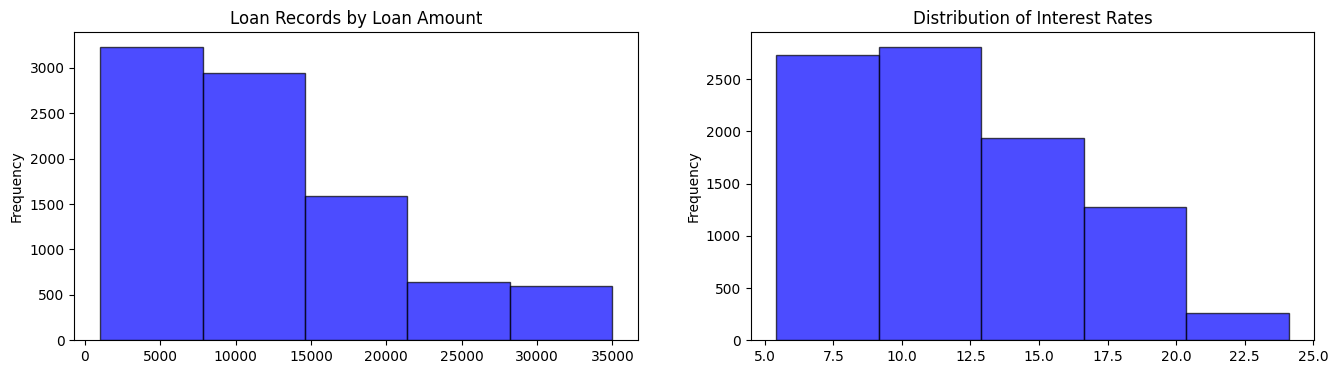

In [4]:
fig,axss = plt.subplots(1,2, figsize=[16,4])
df["loan_amnt"].plot(kind='hist', bins=5, color = 'blue', edgecolor='black', alpha=0.7,title = 'Loan Records by Loan Amount', ax = axss[0])
df["int_rate"].plot(kind='hist', bins=5, color = 'blue', edgecolor='black', alpha=0.7,title = 'Distribution of Interest Rates', ax = axss[1])

In [5]:
# check the distribution of target variable1 loan_status
round(df['loan_status'].value_counts(normalize=True),2)

loan_status
Fully Paid     0.83
Charged Off    0.17
Name: proportion, dtype: float64

In [6]:
# get the % of loss by default
round(1 - sum(df['total_pymnt'][df['loan_status']=='Charged Off'])/sum(df['funded_amnt'][df['loan_status']=='Charged Off']),2)

0.43

#1.2 EDA



###1.2.1 Basic Descriptive Analysis

Most of loans were used for debt consolidation and credit card.

<Axes: title={'center': '% of Loan Records by Loan Purpose'}, ylabel='purpose'>

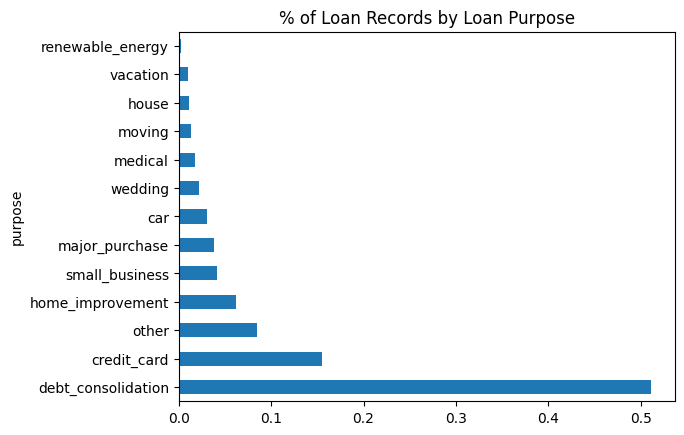

In [7]:
# explore purpose category
df['purpose'].value_counts(normalize=True).plot(kind='barh',title = '% of Loan Records by Loan Purpose')


Most borrowers had less than 10 years of employment, justifying why few of them owned their homes.

<Axes: title={'center': '% of Loan Records by Home Ownership'}, xlabel='home_ownership'>

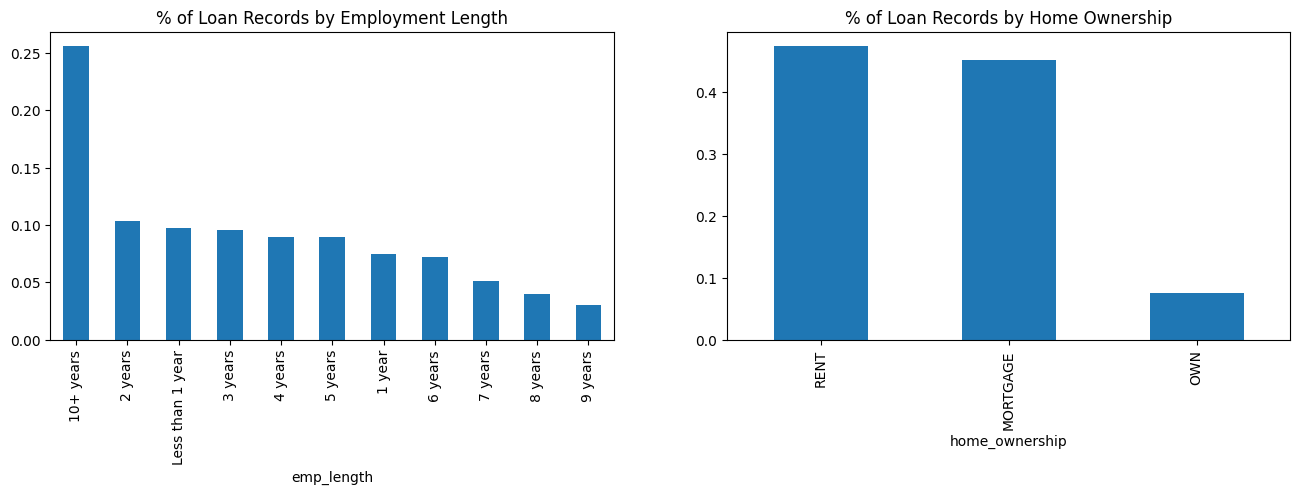

In [8]:
# explore home ownership & emp_length category
fig,axss = plt.subplots(1,2, figsize=[16,4])
df["emp_length"].value_counts(normalize=True).plot(kind='bar',title = '% of Loan Records by Employment Length', ax=axss[0])
df["home_ownership"].value_counts(normalize=True).plot(kind='bar', title = '% of Loan Records by Home Ownership', ax=axss[1])

More loans were insured in CA, TX, FL and NY, which was reasonable since these states were with higher populations or more developed with extensive financial activities.

In [9]:
# total loan counts issued by State
df_location = df.groupby("addr_state",).count().reset_index()
df_location = df_location.filter(["addr_state", "loan_amnt"], axis = 1)

import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=df_location['addr_state'], # Spatial coordinates
    z = df_location['loan_amnt'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Counts",
))

fig.update_layout(
    title_text = 'Total Loans Issued by State',
    geo_scope='usa', # limited map scope to USA
    width=800,  # width of the figure in pixels
    height=600  # height of the figure in pixels
)

fig.show()

The company was aggressive in issuing the loans,with the 40% of the loans granted to borrowers rated <= Grade C and the company issued nearly 100% of the loans the borrowers applied even to borrowers rated <= Grade C.

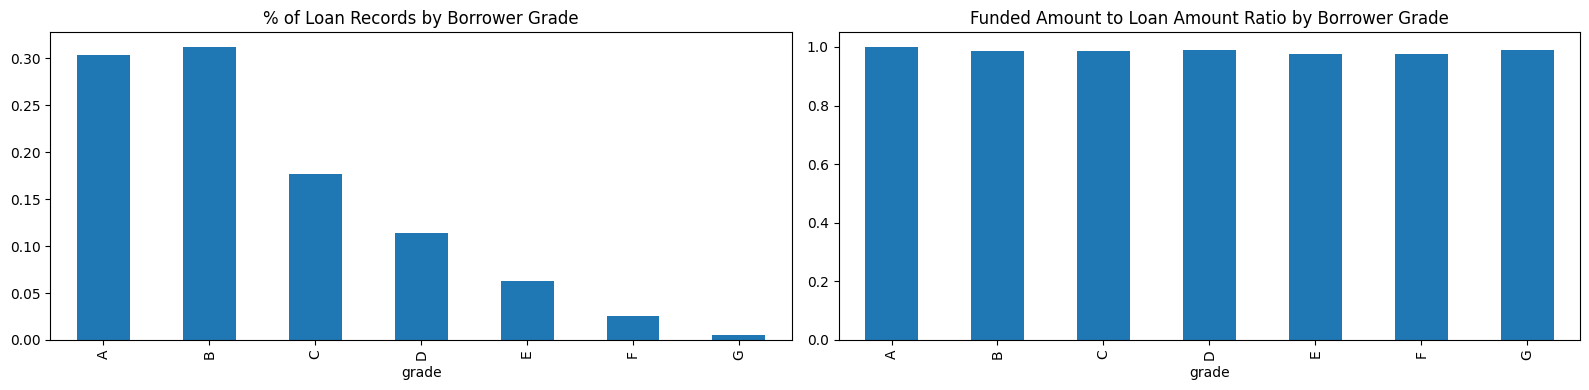

In [10]:
# grade distribution plot & loan approval by grade
fig,axss = plt.subplots(1,2, figsize=[16,4])
df["grade"].value_counts(normalize=True).sort_index().plot(kind='bar', ax = axss[0])

# Calculate the ratio of sums
grouped = df.groupby('grade').sum()
grouped['ratio'] = grouped['funded_amnt'] / grouped['loan_amnt']

# Plotting the ratios
grouped['ratio'].plot(kind='bar')
axss[0].set_title('% of Loan Records by Borrower Grade')
axss[1].set_title('Funded Amount to Loan Amount Ratio by Borrower Grade')

plt.tight_layout()
plt.show()

The DTI limit of 30% implied borrowers should have sufficient income to cover LC installment. However, with over 50% of borrowers using 50% or more of their credit, this high Revolving Line Utilization Rate mirrored the borrowers' overspending, which might contribute to the LC's high default rate.

<Axes: title={'center': 'Loan Records by Revolving Line Utilization Rate'}, ylabel='Frequency'>

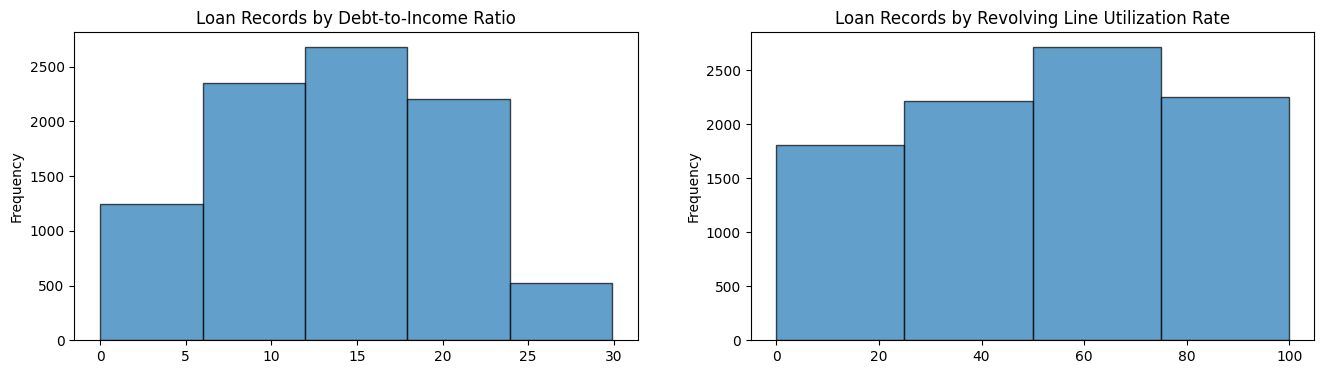

In [11]:
fig,axss = plt.subplots(1,2, figsize=[16,4])
df["dti"].plot(kind='hist', bins=5, edgecolor='black', alpha=0.7,title = 'Loan Records by Debt-to-Income Ratio', ax = axss[0])
df["revol_util"].plot(kind='hist', bins=4, edgecolor='black', alpha=0.7,title = 'Loan Records by Revolving Line Utilization Rate', ax = axss[1])

*earliest_cr_line* was intended to represent the month when a borrower's earliest reported credit line was opened, but it appeared as large integers instead.  This discrepancy suggested this variable might have undergone a transformation using formulas such as datediff('day', initial_date, earliest_cr_line) during the data saving process.

In [12]:
pd.set_option('display.precision', 0)
df["earliest_cr_line"].describe()

count     9004
mean     37300
std       4380
min      19998
25%      34455
50%      36161
75%      42827
max      43076
Name: earliest_cr_line, dtype: float64

### 1.2.2 Correlation Analysis

To better vidualize the relationship between categorical variables vs loan_status and interest rate. We recode some of the variables.

In [13]:
#code loan_status as 0 or 1
df['loan_status'] = [1 if i == 'Charged Off' else 0  for i in df['loan_status'] ]

In [14]:
# recode emp_length
def recode_emp_length(el):
    if el == 'Less than 1 year':
        return '0 - 1 years'
    elif el == '10+ years':
        return '>= 10 years'
    else:
        return el

df['emp_length'] = df['emp_length'].apply(recode_emp_length)

In [15]:
# recode emp_length
def recode_purpose(p):
    if p == 'renewable_energy' or p == 'vacation' or p == 'wedding':
        return 'other'
    elif p == 'house' or p == 'moving' or p == 'home_improvement':
        return 'house'
    else:
        return p

df['purpose'] = df['purpose'].apply(recode_purpose)

#### Categorical Variables vs loan_status

Variables *term*, *grade* and *purpose* might have strong correlation with loan status. The default rate were drastically different by these variables.

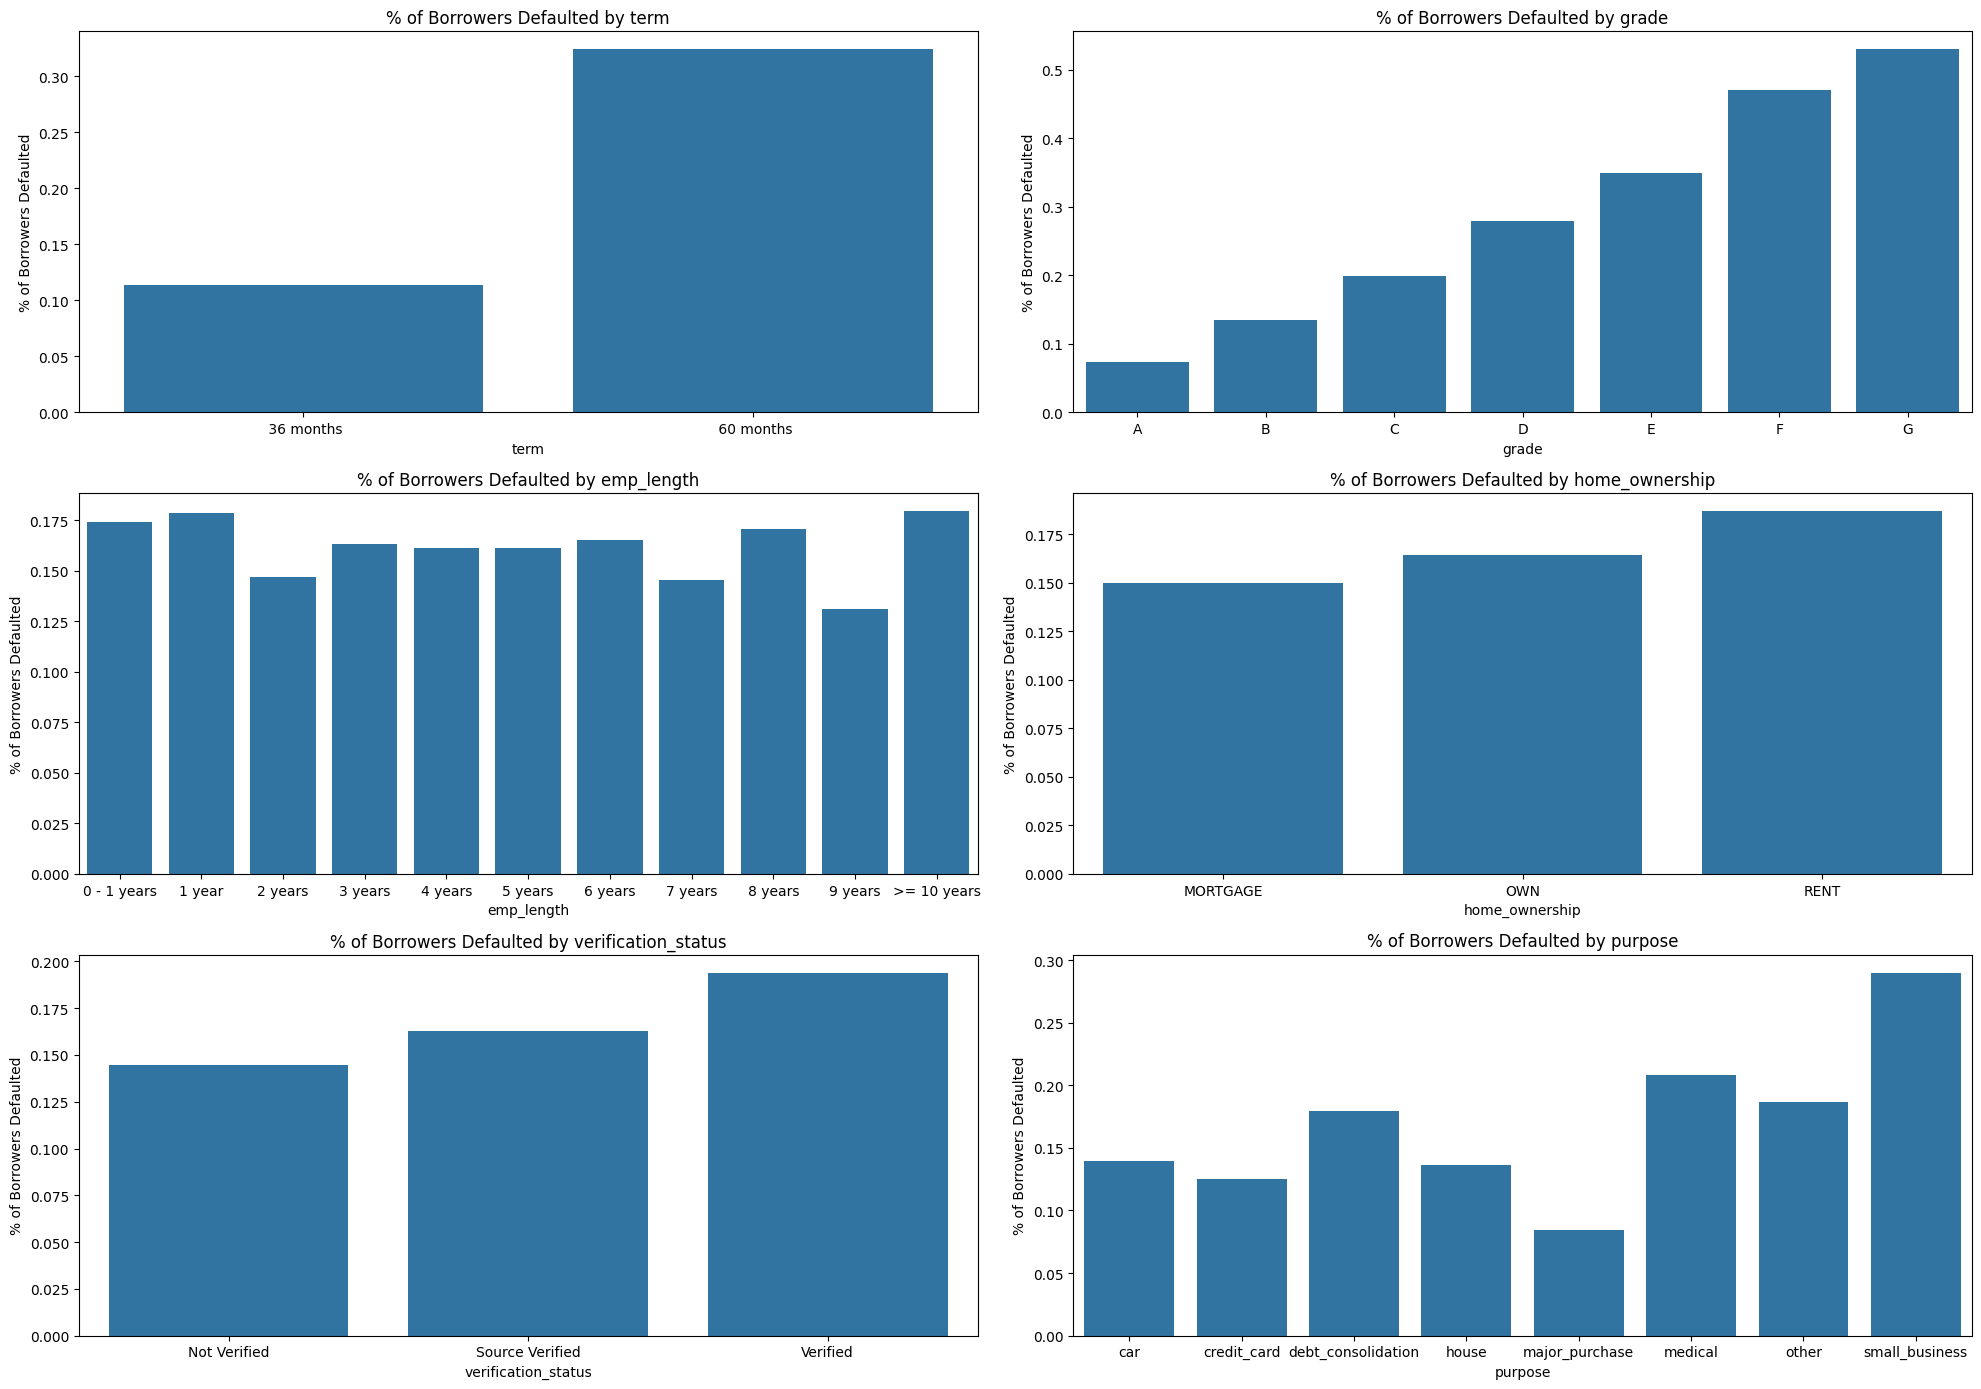

In [16]:
# Define the categories to group by
categories = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose']

# Set up a 3x2 grid of subplots
fig, axss = plt.subplots(3, 2, figsize=(20, 14))
axes_flat = axss.flatten()

# Loop over each category to calculate means and create plots
for i, category in enumerate(categories):

    # Group by category and calculate the default rate
    avg_loan_status = df.groupby(category)['loan_status'].mean().reset_index()

    # Create the barplot on the appropriate subplot
    sns.barplot(x=category, y='loan_status', data=avg_loan_status, ax=axes_flat[i])

    # Set the title for each subplot
    axes_flat[i].set_title(f'% of Borrowers Defaulted by {category}')
    axes_flat[i].set_ylabel('% of Borrowers Defaulted')
    axes_flat[i].set_xlabel(category)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


In [17]:
# default rate issued by State
df_location = df.filter(["addr_state", "loan_status"], axis = 1).groupby("addr_state",).mean().reset_index()

import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=df_location['addr_state'], # Spatial coordinates
    z = df_location['loan_status'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Counts",
))

fig.update_layout(
    title_text = '% of Default by State',
    geo_scope='usa', # limited map scope to USA
    width=800,  # width of the figure in pixels
    height=600  # height of the figure in pixels
)

fig.show()

Note: AK, SD and NV seemed have high default(>25%). However, AK, SD and NM had <= 35 records so it's inconclusive these states had high default.

#### Categorical Variables vs int_rate

 The interest rate was drastically influence by term and grade.

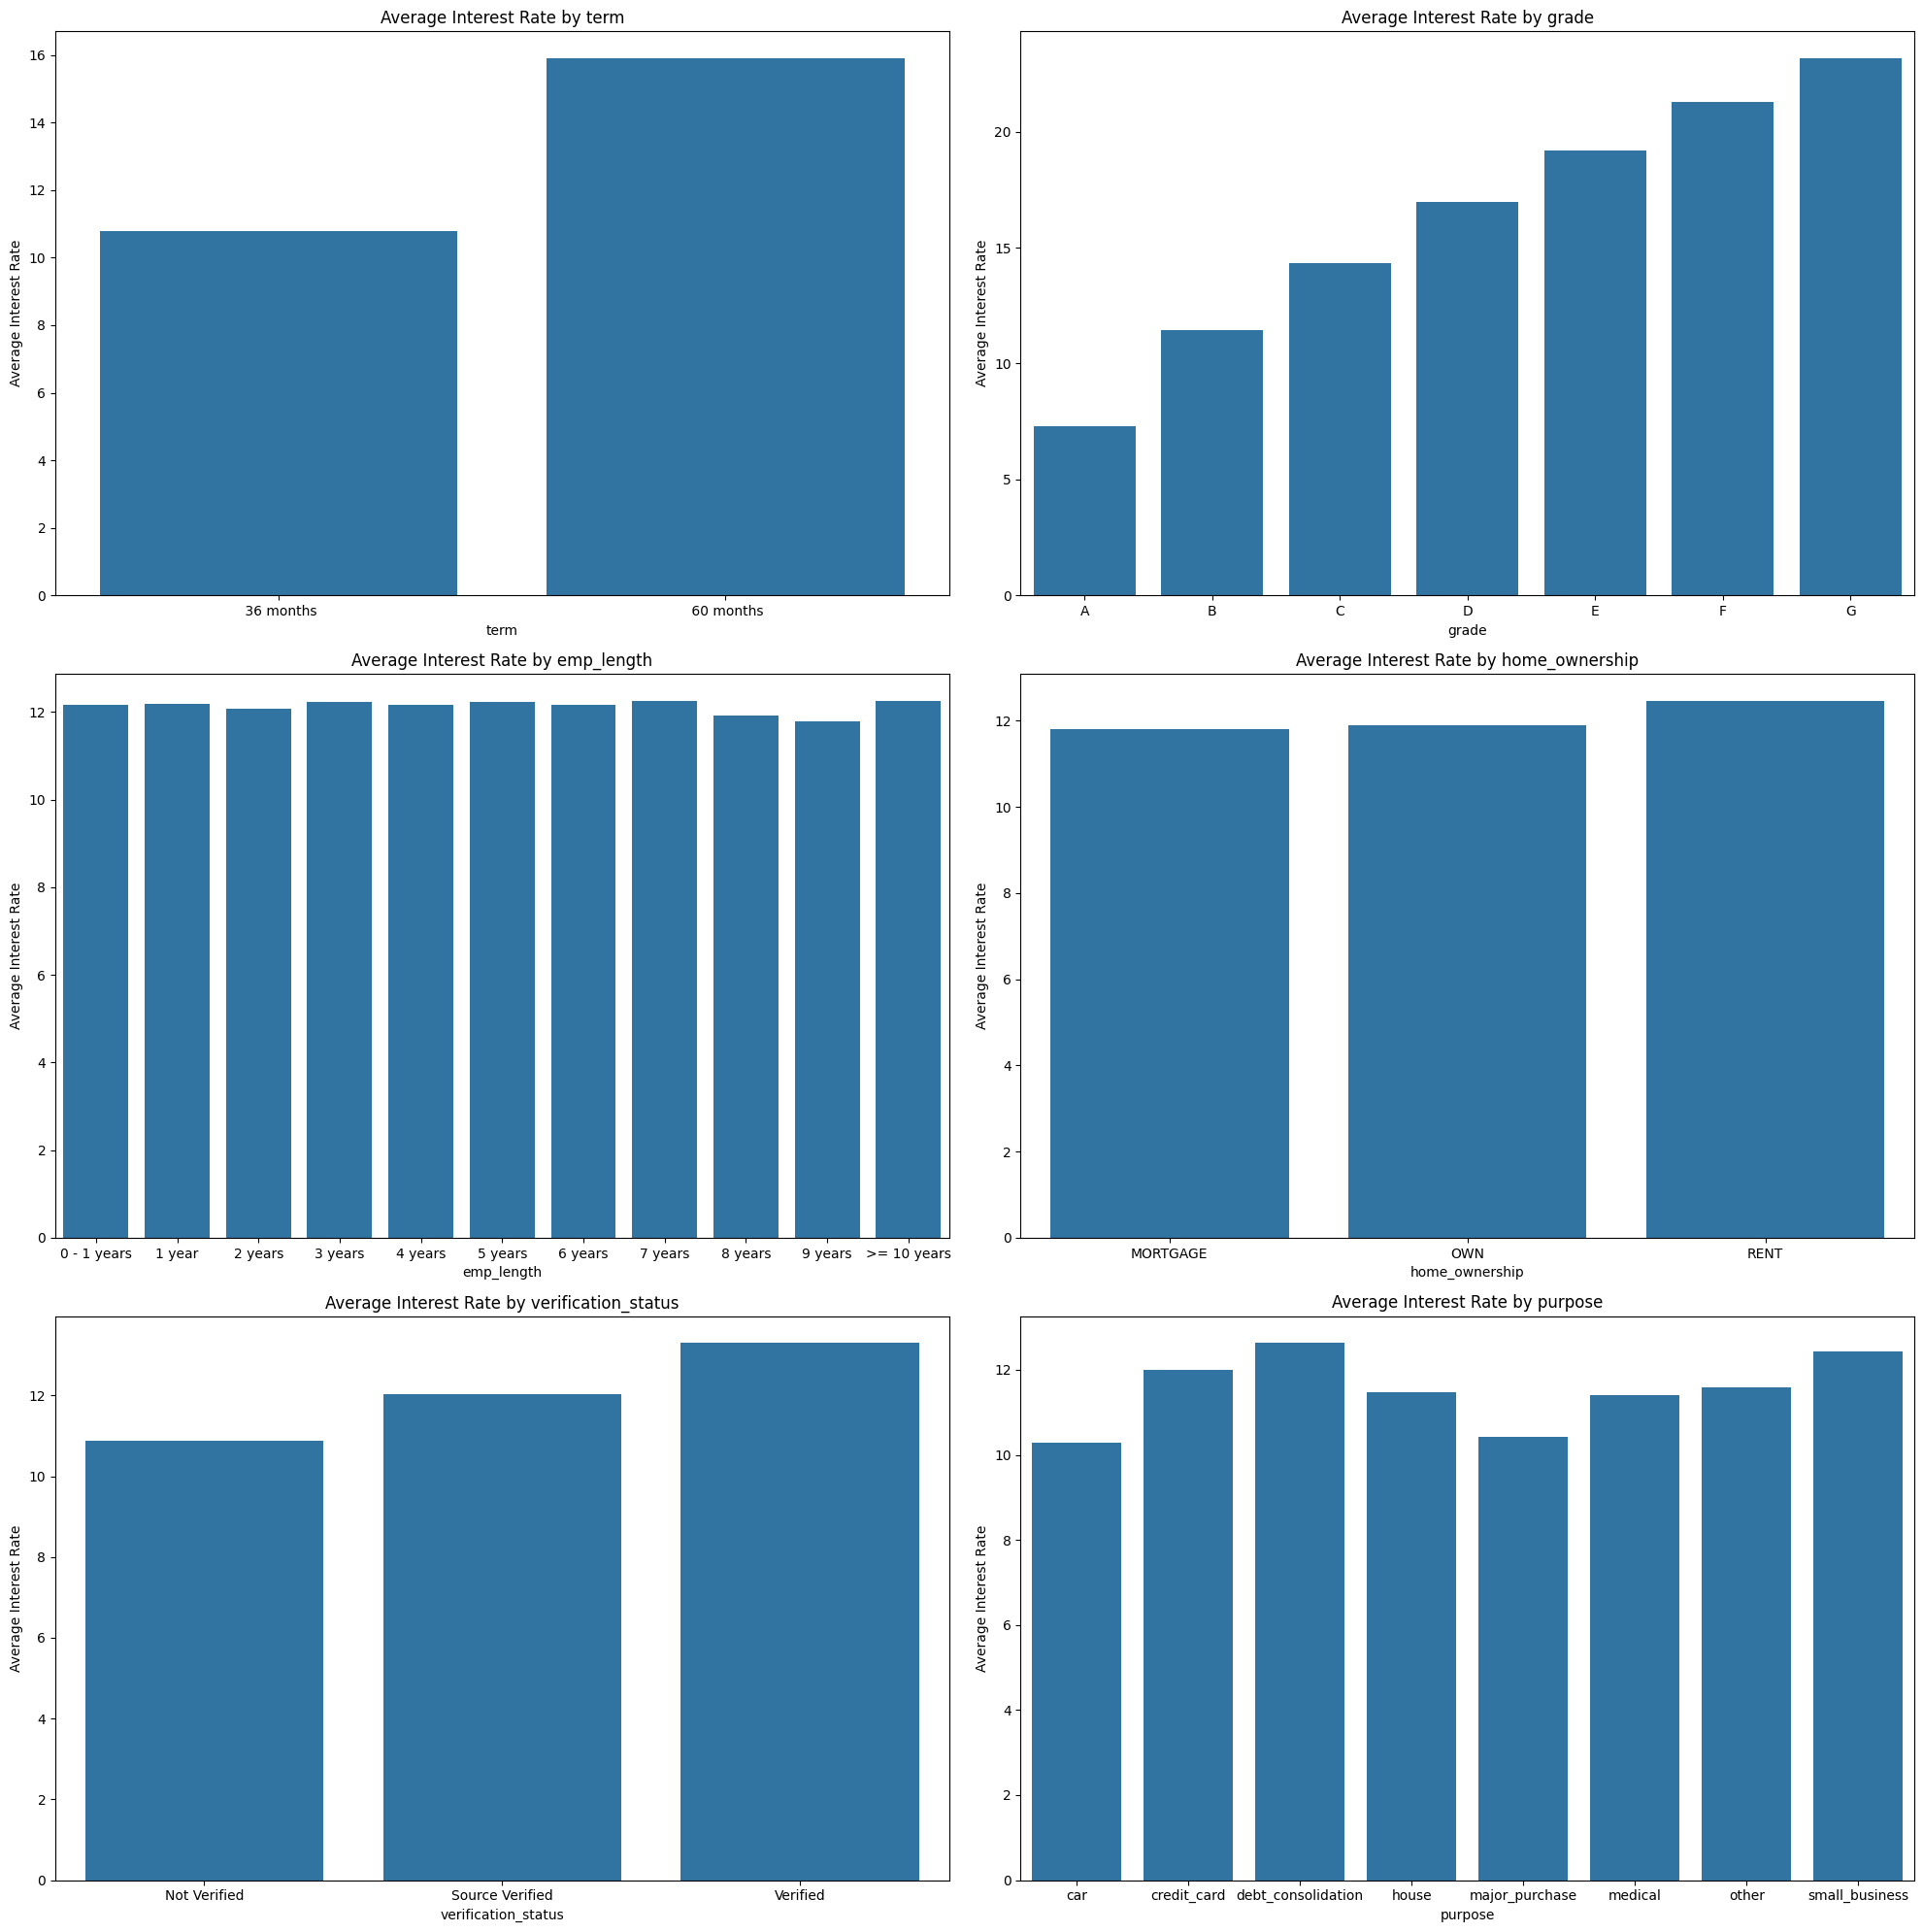

In [18]:
# Define the categories to group by
categories = ['term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose']

# Set up a 3x2 grid of subplots
fig, axss = plt.subplots(3, 2, figsize=(20, 20))
axes_flat = axss.flatten()

# Loop over each category to calculate means and create plots
for i, category in enumerate(categories):

    # Group by category and calculate the default rate
    avg_loan_status = df.groupby(category)['int_rate'].mean().reset_index()

    # Create the barplot on the appropriate subplot
    sns.barplot(x=category, y='int_rate', data=avg_loan_status, ax=axes_flat[i])

    # Set the title for each subplot
    axes_flat[i].set_title(f'Average Interest Rate by {category}')
    axes_flat[i].set_ylabel('Average Interest Rate')
    axes_flat[i].set_xlabel(category)

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


In [19]:
# interest rate by State
df_location = df.filter(["addr_state", "int_rate"], axis = 1).groupby("addr_state",).mean().reset_index()

import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=df_location['addr_state'], # Spatial coordinates
    z = df_location['int_rate'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Counts",
))

fig.update_layout(
    title_text = 'Interest Rate by State',
    geo_scope='usa', # limited map scope to USA
    width=800,  # width of the figure in pixels
    height=600  # height of the figure in pixels
)

fig.show()

Note: MT and MS seemed had higher interest rates(14% - 16%). However, MT and MS only had 18 and 1 loan records so it was inconlcusive to state these states had higher interest rate.

#### Correlation Analysis Between Numeric Variables

For this analysis, we excluded variables *total_pymnt* , *total_pymnt_inv*, *total_rec_prncp*, *total_rec_int* since this information would be unavailable at the time of predicting whether a borrower would default and when calculating the interest rate. Besides, we did not consider variable *out_prncp* & *out_prncp_inv* since they were all 0s. *id* was also excluded since it would not contribute to default and interest rate prediction.

None of these numeric variables appeared to have a strong linear correlation with loan_status individually. The correlation coefficients between loan_status and other numeric variables, as well as between int_rate and other numeric variables (excluding loan_status), were all less than 0.5.

Variables *loan_amnt*, *funded_amnt*, *funded_amnt_inv*, *installment* were super highly correlated with each other since *funded_amnt*, *funded_amnt_inv*, *installment* were largely determined by *loan_amnt*.

In [20]:
df.drop(['out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','id'], axis = 1 ,inplace = True)

In [21]:
# get correlationship between numeric variables

pd.set_option('display.precision', 4)
#get numeric variables
numCol = []
for col in df:
  # out_prncp & out_prncp_inv were removed because they were all 0s
  if df[col].dtype == float or df[col].dtype == int:
    numCol.append(col)

corr = df[numCol].corr()

corr_score = df[numCol].corr()
corr_score

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,loan_status
loan_amnt,1.0000,0.9911,0.9886,0.3084,0.9452,0.3748,0.0268,-0.2085,0.0311,0.1659,-0.0570,0.3292,0.0202,0.2662,0.0871
funded_amnt,0.9911,1.0000,0.9977,0.3034,0.9598,0.3735,0.0256,-0.2047,0.0344,0.1661,-0.0582,0.3275,0.0211,0.2636,0.0839
funded_amnt_inv,0.9886,0.9977,1.0000,0.3029,0.9592,0.3716,0.0252,-0.2040,0.0362,0.1655,-0.0580,0.3254,0.0224,0.2617,0.0844
int_rate,0.3084,0.3034,0.3029,1.0000,0.2679,0.0761,0.0916,0.1062,0.1995,0.0385,0.0984,0.1022,0.4709,-0.0149,0.2645
installment,0.9452,0.9598,0.9592,0.2679,1.0000,0.3852,0.0175,-0.1818,0.0307,0.1638,-0.0527,0.3257,0.0565,0.2432,0.0435
annual_inc,0.3748,0.3735,0.3716,0.0761,0.3852,1.0000,-0.1769,-0.2457,0.0482,0.2026,-0.0259,0.3693,-0.0053,0.3191,-0.0697
dti,0.0268,0.0256,0.0252,0.0916,0.0175,-0.1769,1.0000,-0.0468,0.0252,0.2859,-0.0165,0.2133,0.2435,0.2242,0.0553
earliest_cr_line,-0.2085,-0.2047,-0.2040,0.1062,-0.1818,-0.2457,-0.0468,1.0000,-0.0104,-0.2004,-0.0468,-0.2789,0.0538,-0.4002,0.0211
inq_last_6mths,0.0311,0.0344,0.0362,0.1995,0.0307,0.0482,0.0252,-0.0104,1.0000,0.1075,0.0335,-0.0273,-0.0585,0.1259,0.0695
open_acc,0.1659,0.1661,0.1655,0.0385,0.1638,0.2026,0.2859,-0.2004,0.1075,1.0000,0.0010,0.2766,-0.1034,0.6741,-0.0058


[Text(0.5, 0, 'loan_amnt'),
 Text(1.5, 0, 'funded_amnt'),
 Text(2.5, 0, 'funded_amnt_inv'),
 Text(3.5, 0, 'int_rate'),
 Text(4.5, 0, 'installment'),
 Text(5.5, 0, 'annual_inc'),
 Text(6.5, 0, 'dti'),
 Text(7.5, 0, 'earliest_cr_line'),
 Text(8.5, 0, 'inq_last_6mths'),
 Text(9.5, 0, 'open_acc'),
 Text(10.5, 0, 'pub_rec'),
 Text(11.5, 0, 'revol_bal'),
 Text(12.5, 0, 'revol_util'),
 Text(13.5, 0, 'total_acc'),
 Text(14.5, 0, 'loan_status')]

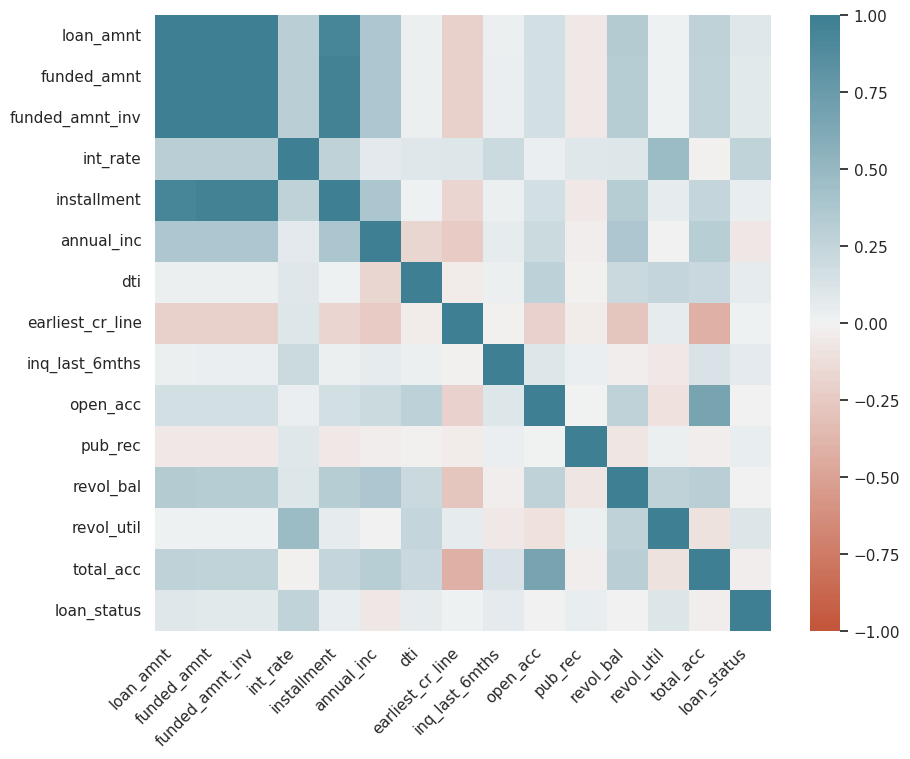

In [22]:
sns.set()

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

### 1.2.3 Outlier Detection


In this session, we excluded *funded_amnt*, *funded_amnt_inv* and *installment* since they were highly correlated with *loan_amnt*.

In [23]:
df = df.drop(['funded_amnt', 'funded_amnt_inv','installment'], axis = 1)


For  *int_rate* ,*dti*, *inq_last_6mths* , and *pub_rec* the difference between min vs 5th percentile and max vs 95th percentile was small so there variables had no outlier.

In [24]:
df.drop('loan_status',axis = 1).describe(percentiles=[0.05,0.5,0.95])

,loan_amnt,int_rate,annual_inc,dti,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
count,9004.0000,9004.0000,9.0040e+03,9004.00,9004.0000,9004.0000,9004.0000,9004.0000,9004.0000,9001.0000,9004.0000
mean,12291.8842,12.1267,6.9577e+04,13.89,37300.4628,0.8572,9.4298,0.0474,13658.4161,52.3688,22.4386
std,8285.6822,4.1957,4.8858e+04,6.61,4379.6522,1.0440,4.2638,0.2157,15038.8254,27.6448,11.1465
min,1000.0000,5.4200,6.0000e+03,0.00,19998.0000,0.0000,2.0000,0.0000,0.0000,0.0000,3.0000
5%,2500.0000,6.0300,2.5000e+04,2.97,30742.0000,0.0000,4.0000,0.0000,613.2000,4.3000,7.0000
50%,10000.0000,11.7100,6.0000e+04,13.94,36161.0000,1.0000,9.0000,0.0000,9889.0000,54.7000,21.0000
95%,30000.0000,19.4200,1.4700e+05,24.20,43040.0000,3.0000,17.0000,0.0000,38496.6500,93.8000,43.0000
max,35000.0000,24.1100,1.7820e+06,29.92,43076.0000,8.0000,34.0000,2.0000,148804.0000,99.9000,79.0000


For the rest numeric variable, we considered values that fall more than 3 standard deviations away from the mean, either above or below, to be outliers.

Variables *annual_inc*,*open_acc*, *revol_bal* and *total_acch* had outliers. *revol_bal* had more outliers, with 2% of values were outliers.

In [25]:
def get_outlier_record(column):
  '''
  This function aimed to get the records with outlier for input column
  The outlier was away from +3/-3 of sd
  '''
  mean = df[column].mean()
  std_dev = df[column].std()

  # Calculate the cutoff for outliers
  cutoff = 3 * std_dev
  lower, upper = mean - cutoff, mean + cutoff

  # Identify outliers
  return  df[(df[column] < lower) | (df[column] > upper)]




In [26]:
#get columns with outliers
numCol = ['loan_amnt','annual_inc','earliest_cr_line','open_acc', 'revol_bal','revol_util','total_acc']
for column in numCol:
  outliers_df = get_outlier_record(column)
  # Identify outliers
  outliers = round(outliers_df.shape[0]/df.shape[0] * 100,0)

  # Print outliers
  if  outliers:
    print(f"% of Outliers in {column}: {outliers}%")


% of Outliers in annual_inc: 1.0%
% of Outliers in open_acc: 1.0%
% of Outliers in revol_bal: 2.0%
% of Outliers in total_acc: 1.0%



*   The outliers in *revol_bal*, *open_acc*, and *total_acc* were higher values, likely genuine because borrowers with high revolving balances usually had more accounts, and vice versa. Generally, the more accounts a borrower has, the higher the balances they might accumulate, and vice versa.
*    The outliers in annual income were higher values, which were likely genuine given that average income typically increases with years of employment.




In [27]:
#revol_bal outlier exploration
revol_bal = get_outlier_record('revol_bal')
df_revol = pd.concat([revol_bal['revol_bal'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['revol_bal'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_revol.columns = ['revol_bal_outliers','revol_bal_all_data']
df_revol.loc

In [28]:
#open_acc by revol_bal outlier vs grand total
df_revol = pd.concat([revol_bal['open_acc'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['open_acc'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_revol.columns = ['open_acc_revol_bal_outliers','open_acc_all_data']
df_revol.iloc[:-1]

,open_acc_revol_bal_outliers,open_acc_all_data
count,186.0000,9004.0000
mean,12.4677,9.4298
std,4.3199,4.2638
min,5.0000,2.0000
25%,9.0000,6.0000
50%,12.0000,9.0000
75%,16.0000,12.0000
95%,20.0000,17.0000


In [29]:
#income outlier exploration
annual_inc = get_outlier_record('annual_inc')
df_inc = pd.concat([annual_inc['annual_inc'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['annual_inc'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_inc.columns = ['annual_inc_outliers','annual_inc_all_data']
df_inc

,annual_inc_outliers,annual_inc_all_data
count,1.1700e+02,9.0040e+03
mean,3.1998e+05,6.9577e+04
std,1.7381e+05,4.8858e+04
min,2.1800e+05,6.0000e+03
25%,2.4360e+05,4.2000e+04
50%,2.7700e+05,6.0000e+04
75%,3.2000e+05,8.3000e+04
95%,5.2860e+05,1.4700e+05
max,1.7820e+06,1.7820e+06


In [30]:
#income outlier by employment length
income = get_outlier_record('annual_inc')
income['emp_length'].fillna('Unknown' , inplace = True )

<ipython-input-30-0654b1b23f65>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: title={'center': 'Annual Income Outliers by Employment Length'}, xlabel='emp_length'>

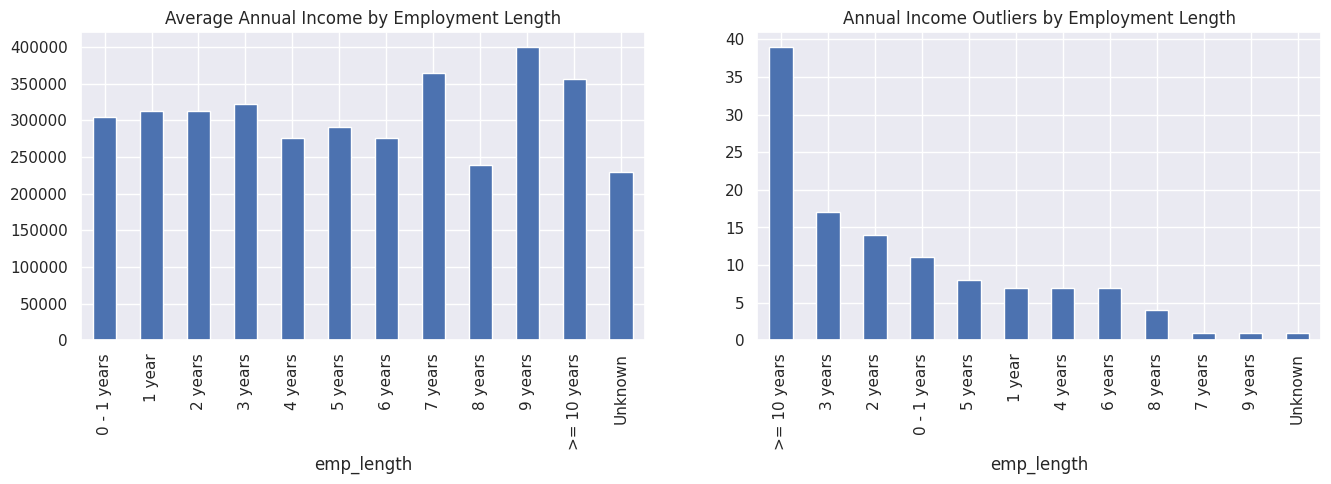

In [31]:
fig,axss = plt.subplots(1,2, figsize=[16,4])
income.groupby('emp_length')['annual_inc'].mean().plot(kind = 'bar' , title = 'Average Annual Income by Employment Length', ax = axss[0])
income['emp_length'].value_counts().plot(kind = 'bar' , title = 'Annual Income Outliers by Employment Length', ax = axss[1])

In [32]:
#total account outlier exploration
total_acc = get_outlier_record('total_acc')
df_total_acc = pd.concat([total_acc['total_acc'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['total_acc'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_total_acc.columns = ['total_acc_outliers','total_acc_all_data']
df_total_acc

,total_acc_outliers,total_acc_all_data
count,100.0000,9004.0000
mean,60.0000,22.4386
std,3.6625,11.1465
min,56.0000,3.0000
25%,57.0000,14.0000
50%,59.0000,21.0000
75%,63.0000,29.0000
95%,63.0000,43.0000
max,79.0000,79.0000


In [33]:
#total_acc by revol_bal outlier vs grand total
df_total_acc = pd.concat([total_acc['revol_bal'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['revol_bal'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_total_acc.columns = ['revol_bal_total_acc_outliers','revol_bal_acc_all_data']
df_total_acc.iloc[:-1]

,revol_bal_total_acc_outliers,revol_bal_acc_all_data
count,100.0000,9004.0000
mean,24824.7600,13658.4161
std,22104.5742,15038.8254
min,722.0000,0.0000
25%,10279.0000,4559.7500
50%,18540.5000,9889.0000
75%,29355.7500,17468.2500
95%,67014.0000,38496.6500


In [34]:
#open account outlier exploration
open_acc = get_outlier_record('open_acc')
df_open_acc = pd.concat([total_acc['open_acc'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['open_acc'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_open_acc.columns = ['open_acc_outliers','open_acc_all_data']
df_open_acc

,open_acc_outliers,open_acc_all_data
count,100.000,9004.0000
mean,18.140,9.4298
std,5.995,4.2638
min,5.000,2.0000
25%,15.000,6.0000
50%,18.000,9.0000
75%,22.000,12.0000
95%,30.000,17.0000
max,34.000,34.0000


In [35]:
#open_acc by revol_bal outlier vs grand total
df_open_acc = pd.concat([open_acc['revol_bal'].describe(percentiles=[0.25,0.5,0.75,0.95]),df['revol_bal'].describe([0.25,0.5,0.75,0.95]) ], axis = 1)
df_open_acc.columns = ['revol_bal_total_acc_outliers','revol_bal_acc_all_data']
df_open_acc.iloc[:-1]

,revol_bal_total_acc_outliers,revol_bal_acc_all_data
count,78.0000,9004.0000
mean,22658.6282,13658.4161
std,24676.7114,15038.8254
min,336.0000,0.0000
25%,7721.7500,4559.7500
50%,17026.0000,9889.0000
75%,27265.5000,17468.2500
95%,65101.9000,38496.6500


# Part 2: Data cleaning and Feature Preprocessing


## 2.1 Missing Value

We filled missing values of *emp_length* with unknown as a new category.

*revol_util* had only 3 missing values so we can simply impute these with variable mean.



In [36]:
df['emp_length'] = df['emp_length'].fillna('Unknown')

In [37]:
df['revol_util'].fillna(df['revol_util'].mean(),inplace = True)

## 2.2 Categorical Variable to Numeric Varaible

For *earliest_cr_line*, since we were unsure of the initial date from which the variable was transformed, we decided to evenly group its values into five buckets and then encode these into five binary variables.

In [38]:
df['credit_history_length'] = pd.cut(df['earliest_cr_line'], bins=4, labels=["very_long", "long", "recent", "very_recent"])


In [39]:
# recode emp_length
def recode_emp_length(el):
    if el in ['0 - 1 years','2 years','1 year']:
        return '0 - 2 years'
    elif el in ['3 years','4 years','5 years']:
        return '3 - 5 years'
    elif el in ['6 years','7 years','8 years','9 years']:
        return '6 - 9 years'
    else:
        return el

df['emp_length'] = df['emp_length'].apply(recode_emp_length)

In [40]:
# recode addr_state, only keep states with top 5 loans issued
def recode_addr(s):
    if s in ['CA','NY','FL','TX','NJ']:
        return s
    else:
        return 'Others'

df['addr_state'] = df['addr_state'].apply(recode_addr)

In [41]:
df_encoded = pd.get_dummies(df,[ 'term', 'grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose','addr_state','credit_history_length'])

## 2.3 Drop Unneccessary Variables

We included only those variables that did not exhibit high correlation with other variables and would not cause data leakage.

In [42]:
#drop unneccesary variables
df_encoded = df_encoded.drop(['term_ 60 months','grade_G','home_ownership_OWN',
              'verification_status_Not Verified', 'purpose_other','addr_state_Others','emp_length_Unknown','credit_history_length_recent'],axis = 1)

In [43]:
df_encoded.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'loan_status', 'term_ 36 months', 'grade_A', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'emp_length_0 - 2 years',
       'emp_length_3 - 5 years', 'emp_length_6 - 9 years',
       'emp_length_>= 10 years', 'home_ownership_MORTGAGE',
       'home_ownership_RENT', 'verification_status_Source Verified',
       'verification_status_Verified', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_house', 'purpose_major_purchase',
       'purpose_medical', 'purpose_small_business', 'addr_state_CA',
       'addr_state_FL', 'addr_state_NJ', 'addr_state_NY', 'addr_state_TX',
       'credit_history_length_very_long', 'credit_history_length_long',
       'credit_history_length_very_recent'],
      dtype='object')

## 2.4 Outlier Imputation

For variables with outliers, we imputed these extreme values using their 99th percentile to minimize their distortion on the candidate machine learning models.

In [44]:
columns = ['annual_inc', 'revol_bal', 'total_acc','open_acc']  # List of columns to process

for column in columns:
    percentile_99 = df_encoded[column].quantile(0.99)
    df_encoded[column] = df_encoded[column].apply(lambda x: percentile_99 if x > percentile_99 else x)

## 2.5 Data Processing

We divided the data into training and control sets for modeling purposes and standardized the data to improve model performance.

In [45]:
# split dataset
from sklearn.model_selection import train_test_split

y = df_encoded.loan_status
X = df_encoded.drop(["loan_status"], axis=1)

# Reserve 25% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)
# standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_sd = scaler.transform(X_train)
X_test_sd = scaler.transform(X_test)

Note: Random Forest Classifier and Regressor would use orginal data but not standardized.

# Part 3: Model Training and Selection

## 3.1 Modeling for loan_status

We developed Logistic Regression, RandomForest, Nerual Network models to predict loan status, optimizing for recall to effectively identify defaults.







###3.1.1 Model Fitting & Performance Evaluation

The Random Forest model outperformed the other three models, achieving the highest recall and demonstrating efficient model fitting. It correctly identified 72% of fully paid loans and 63% of defaults.

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

# Logistic Regression
classifier_logistic = LogisticRegression()

# Random Forest
classifier_RF = RandomForestClassifier()

#nerual network
mlp = MLPClassifier()

In [47]:
#logistic modeling
param_grid_logistic = {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'],'solver': ['liblinear'], 'class_weight': [None, 'balanced']}
grid_search_logistic = GridSearchCV(classifier_logistic, param_grid_logistic, cv=5, scoring='recall')
grid_search_logistic.fit(X_train_sd, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'class_weight': [None, 'balanced'],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='recall')

In [48]:
#logistic performance
prediction_Regression = grid_search_logistic.predict(X_test_sd)
print(classification_report(y_test,prediction_Regression))

              precision    recall  f1-score   support

           0       0.92      0.70      0.79      1872
           1       0.31      0.68      0.43       379

    accuracy                           0.70      2251
   macro avg       0.61      0.69      0.61      2251
weighted avg       0.81      0.70      0.73      2251



In [49]:
grid_search_logistic.best_estimator_

LogisticRegression(C=10, class_weight='balanced', penalty='l1',
                   solver='liblinear')

In [50]:
#RF modeling
#1 minite to train
param_grid_RF = {'n_estimators': [ 50, 100, 200],'max_depth': [5, 6, 7], 'max_features': ['sqrt'],'class_weight': [None, 'balanced']}
grid_search_RF = GridSearchCV(classifier_RF, param_grid_RF, cv=5, scoring='recall')
grid_search_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [5, 6, 7], 'max_features': ['sqrt'],
                         'n_estimators': [50, 100, 200]},
             scoring='recall')

In [51]:
#RF performance
prediction_RF = grid_search_RF.predict(X_test)
print(classification_report(y_test,prediction_RF))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1872
           1       0.32      0.64      0.43       379

    accuracy                           0.71      2251
   macro avg       0.62      0.68      0.62      2251
weighted avg       0.81      0.71      0.74      2251



In [52]:
grid_search_RF.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=200)

In [53]:
#9 minutes to train
# Nerual Netwrok
parameter_grid_mlp = {
    'hidden_layer_sizes': [ (50,50), (100,100),(50,50,50),(100,100,100)],
    'solver': ['sgd', 'adam'],
    'alpha': [0.001, 0.01,0.1],
    'learning_rate': ['adaptive'],
}

mlp = MLPClassifier(max_iter=100)  # You might want to add or adjust other fixed parameters

# Create a GridSearchCV object
grid_search_mlp = GridSearchCV(mlp, parameter_grid_mlp, n_jobs=-1, cv=5)
grid_search_mlp.fit(X_train_sd, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.



GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=100), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(50, 50), (100, 100),
                                                (50, 50, 50), (100, 100, 100)],
                         'learning_rate': ['adaptive'],
                         'solver': ['sgd', 'adam']})

In [54]:
#Nerual Netwrok performance
prediction_mlp = grid_search_mlp.predict(X_test)
print(classification_report(y_test,prediction_RF))

              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1872
           1       0.32      0.64      0.43       379

    accuracy                           0.71      2251
   macro avg       0.62      0.68      0.62      2251
weighted avg       0.81      0.71      0.74      2251



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names



In [55]:
grid_search_mlp.best_estimator_

MLPClassifier(alpha=0.1, hidden_layer_sizes=(50, 50, 50),
              learning_rate='adaptive', max_iter=100, solver='sgd')

###3.1.2 Feature Importance

The most influential features for predicting borrower defaults were associated with the term and interest of the loan and if a borrower was grade A. Surprisingly, the borrower's credit grade had less impact than anticipated, primarily because it showed a strong correlation with the interest rate.

In [56]:
# check feature importance of logistics regression
forest_best = RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50)
forest_best.fit(X, y)

importances = forest_best.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(X.shape[1]):
  print ("{0} : {1}".format(X.columns[indices[ind]],round(importances[indices[ind]], 2)))

Feature importance ranking by Random Forest Model:
term_ 36 months : 0.23
int_rate : 0.22
grade_A : 0.11
annual_inc : 0.08
revol_util : 0.06
dti : 0.03
grade_E : 0.03
loan_amnt : 0.03
earliest_cr_line : 0.02
revol_bal : 0.02
grade_D : 0.02
grade_F : 0.02
total_acc : 0.02
grade_B : 0.02
purpose_credit_card : 0.01
inq_last_6mths : 0.01
open_acc : 0.01
purpose_small_business : 0.01
grade_C : 0.01
home_ownership_MORTGAGE : 0.01
home_ownership_RENT : 0.0
purpose_house : 0.0
addr_state_TX : 0.0
addr_state_CA : 0.0
purpose_major_purchase : 0.0
verification_status_Verified : 0.0
credit_history_length_very_recent : 0.0
emp_length_>= 10 years : 0.0
emp_length_6 - 9 years : 0.0
addr_state_NY : 0.0
verification_status_Source Verified : 0.0
addr_state_FL : 0.0
emp_length_3 - 5 years : 0.0
purpose_debt_consolidation : 0.0
pub_rec : 0.0
emp_length_0 - 2 years : 0.0
addr_state_NJ : 0.0
purpose_medical : 0.0
purpose_car : 0.0
credit_history_length_long : 0.0
credit_history_length_very_long : 0.0


## 3.2 Modeling for interest int_rate

We developed Linear Regression, K-Neighbors Regressor, and RandomForest Regressor models to predict interest rates, focusing on minimizing MSE for more accurate predictions. We excluded records indicating defaults, as these problematic loans may not provide valuable insights for establishing rules for interest rate settings.

### 3.2.1 Model Fitting and Performance Evaluation

Lasso was the best model. The error rate in interest rate prediciton was only 6%.

In [57]:
# remove defaults
int_df = df_encoded[df_encoded.loan_status == 0]

In [58]:
y_int = int_df.int_rate
X_int = int_df.drop(["loan_status","int_rate"], axis=1)

# Reserve 25% for testing
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(X_int, y_int, random_state=42, test_size=.25)

#standardize
scaler.fit(X_train_int)
X_train_sd_int = scaler.transform(X_train_int)
X_test_sd_int = scaler.transform(X_test_int)

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso

# Linear Regression
regressor_lasso = Lasso()

# K Nearest Neighbors Regressor
regressor_KNN = KNeighborsRegressor()

# Random Forest Regressor
regressor_RF = RandomForestRegressor()

In [60]:
#logistic modeling
param_grid_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_lasso = GridSearchCV(Lasso(), param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
grid_search_lasso.fit(X_train_sd_int, y_train_int)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='neg_mean_squared_error')

In [61]:
# get absolute interest error rate lasso
round(sum(abs(y_test_int- grid_search_lasso.predict(X_test_sd_int) ))/sum(y_test_int),2)

0.06

In [62]:
#KNN
param_grid_KNN = {'n_neighbors': [5,7,9,11],  # Test different neighbors
    'weights': ['uniform', 'distance'],  # Test uniform and distance weights
    'metric': ['euclidean', 'manhattan', 'minkowski']}  # Test different distance metrics}
grid_search_KNN  = GridSearchCV(regressor_KNN,param_grid_KNN, cv=5, scoring='neg_mean_squared_error')
grid_search_KNN.fit(X_train_sd_int, y_train_int)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [63]:
# get absolute interest error rate KNN
round(sum(abs(y_test_int - grid_search_KNN.predict(X_test_sd_int) ))/sum(y_test_int),2)

0.08

In [64]:
param_grid_RF = {'n_estimators': [ 50, 100, 200],'max_depth': [5, 6, 7], 'max_features': ['sqrt']}
grid_search_RF = GridSearchCV(regressor_RF, param_grid_RF, cv=5, scoring='neg_mean_squared_error')
grid_search_RF.fit(X_train_int, y_train_int)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 6, 7], 'max_features': ['sqrt'],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [65]:
# get absolute interest error rate KNN
round(sum(abs(y_test_int - grid_search_RF.predict(X_test_sd_int) ))/sum(y_test_int),2)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



0.1

### 3.2.2 Feature Importance

Borrower's grade largely determine the interest rate for the loan. The higher the grade, the lower the interest rate.

In [66]:
best_lasso = grid_search_lasso.best_estimator_
lasso_coefficients = best_lasso.coef_
feature_coefficients = pd.DataFrame({
    'Feature': X_train_int.columns,
    'Coefficient': lasso_coefficients
})

# Display the DataFrame sorted by the absolute value of coefficients in descending order
print(feature_coefficients.sort_values(by='Coefficient', key=abs, ascending=False))

                                Feature  Coefficient
11                              grade_A      -6.5473
12                              grade_B      -4.7361
13                              grade_C      -2.7813
14                              grade_D      -1.4473
15                              grade_E      -0.6230
8                            revol_util       0.3056
10                      term_ 36 months      -0.2015
4                        inq_last_6mths       0.1233
16                              grade_F      -0.1141
5                              open_acc       0.0768
0                             loan_amnt       0.0738
6                               pub_rec       0.0614
9                             total_acc      -0.0588
39    credit_history_length_very_recent       0.0535
24         verification_status_Verified       0.0523
17               emp_length_0 - 2 years       0.0407
7                             revol_bal      -0.0401
38           credit_history_length_long      -

# Part 5 : Summary

This project focused on predicting loan defaults and interest rates for LendingClub's small loans to enhance its risk management and profitability. LendingClub has been grappling with a high default rate of 17% and a significant loss of 43% on defaulted loans for the small loan business, likely due to its aggressive loan issuance strategy. Notably, 40% of its loans are issued to borrowers <= grade C for nearly the full amount requested, and over 50% of small loan borrowers have issues with overspending.

The raw data was relatively clean. Only 4 variables exhibited 1-2% outliers, which could be validated as genuine through cross-validation with other variables. Additionally, 3% of the records had missing values, primarily in the *revol_util* and *emp_length* fields.

To optimize model performance, we implemented several strategies: imputing missing values with the average or a new class, capping outliers at the 99th percentile, encoding categorical variables, removing variables that could cause data leakage or were highly correlated with other variables, and standardizing data when necessary.

In terms of default predictions, the Random Forest model had the best performance, correctly identifying 72% of fully-paid loans and 63% of defaults. The most critical features influencing borrower defaults were loan term and interest rate, alongside the borrower's grade.

For predicting interest rates, Lasso regression was most effective, demonstrating a low error rate of 6%. This strong model performance was likely due to the significant influence of borrowers' credit characteristics on interest rates.

# Part 6 : Future improvement

1. To enhance the performance of default prediction models, we could weight the sample defaulted based on the potential profit loss from incorrect predictions of defaults vs fully-paid, rather than merely weighting by the its sample size vs that of fully-paid.

2. Instead of merely modeling whether a loan defaults, we could focus on predicting the total payment LendingClub will receive. This approach would provide insights into whether to issue the full or partial loan amount to minimize risk.

3. For interest rate predictions, considering only non-defaulting records might yield more conservative results. To optimize interest rates, we could employ the *optimization* module in *scipy*, applying reasonable constraints on the risk premium to maximize loan payments.